In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 6
commitnumber = d62b618
conc = 1.8e-06
dv = 0.005
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [2, 4]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 300
vmax = 1215
vmin = 1100
w_diffuse = [(1.66, 1.66), (1.66, 1.66, 1.66, 1.66)]
wgt = [(1, 1), (1, 1, 1, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

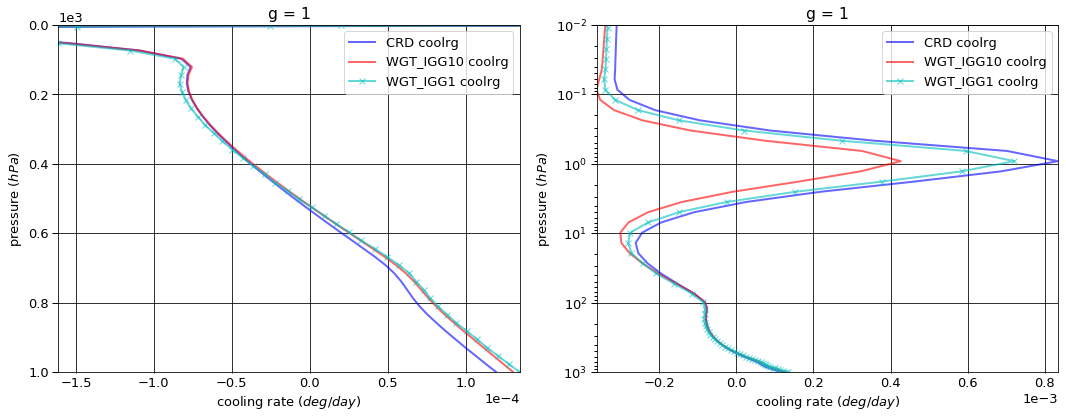

# Figure: cooling rate g-group 2

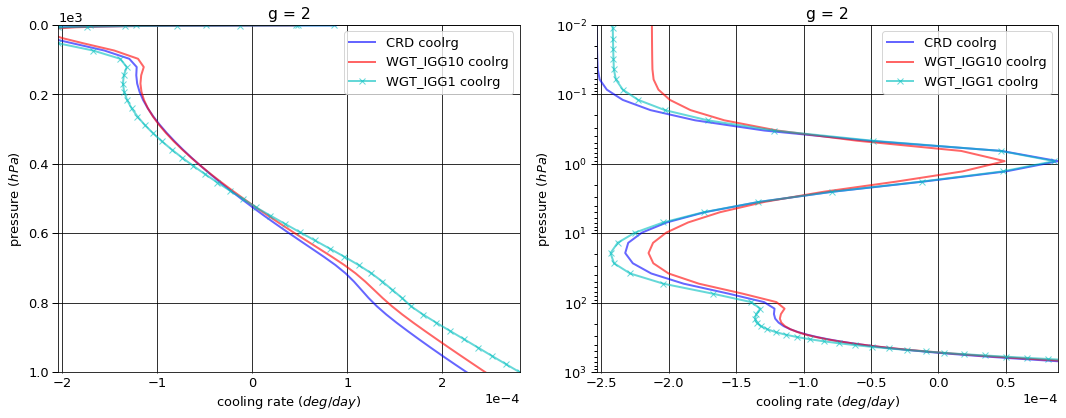

# Figure: cooling rate g-group 3

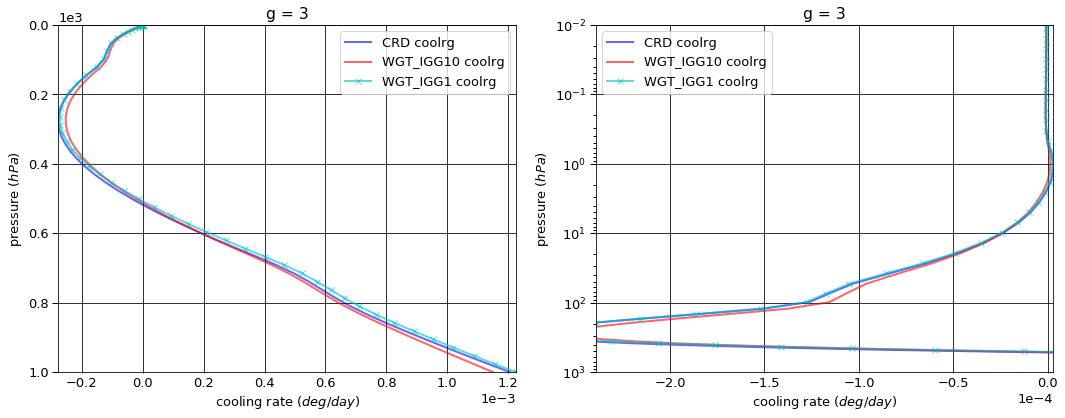

# Figure: cooling rate g-group 4

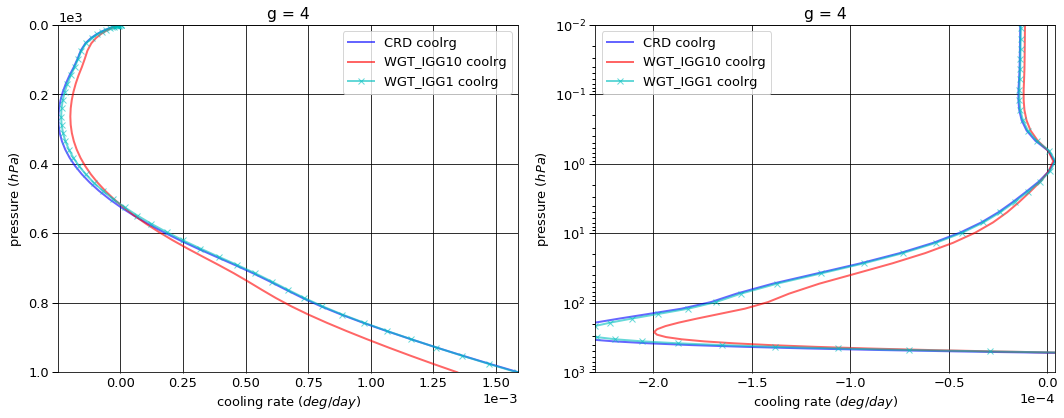

# Figure: cooling rate g-group 5

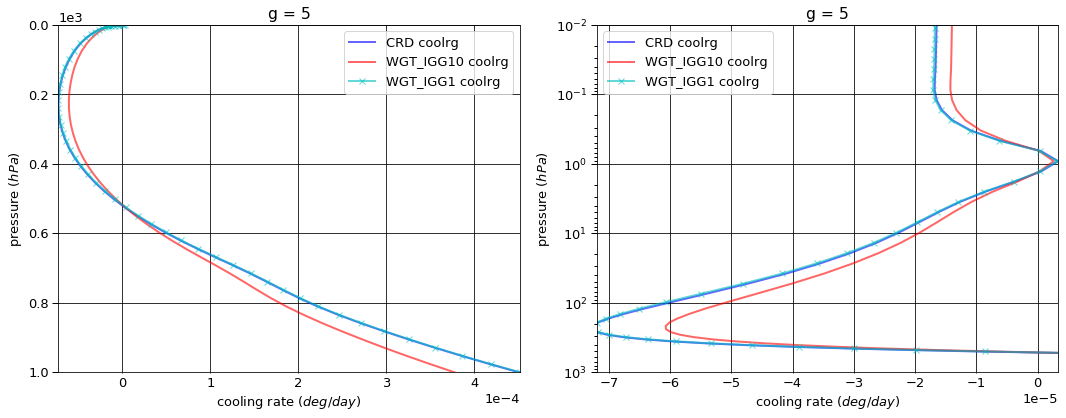

# Figure: cooling rate g-group 6

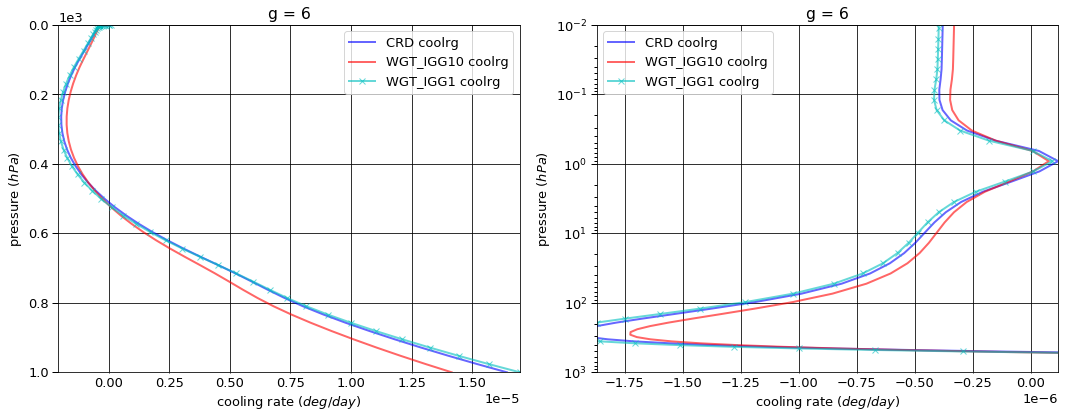

# Figure: cooling rate g-group total

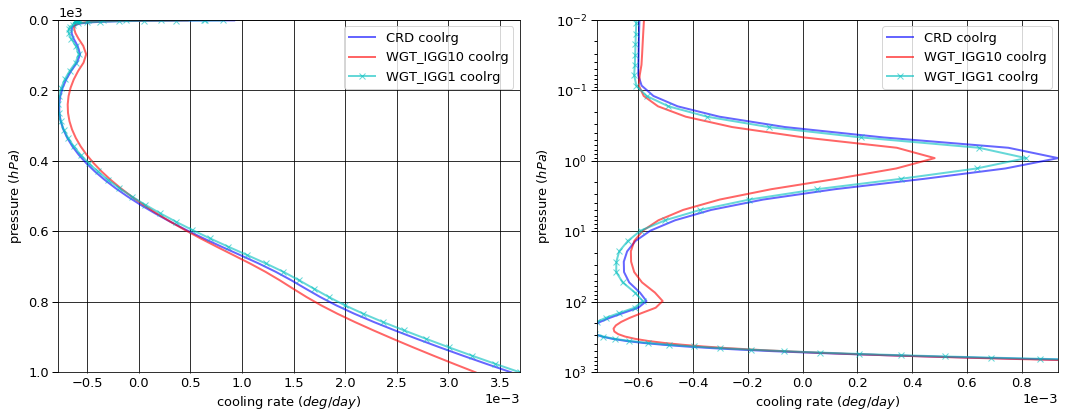

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.039249  0.000000  -0.039249
  1013.0   76     -0.048371  0.008372  -0.039999
2 0.0      1      -0.488135  0.000000  -0.488135
  1013.0   76     -0.501211  0.013620  -0.487591
3 0.0      1      -0.487670  0.000000  -0.487670
  1013.0   76     -0.525404  0.061877  -0.463527
4 0.0      1      -5.206967  0.000000  -5.206967
  1013.0   76     -5.242137  0.065991  -5.176146
5 0.0      1     -14.282525  0.000000 -14.282525
  1013.0   76    -14.292329  0.018177 -14.274152
6 0.0      1      -5.455457  0.000000  -5.455457
  1013.0   76     -5.455752  0.000638  -5.455115


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.037266  0.000000  -0.037266
  1013.0   76     -0.046373  0.008650  -0.037723
2 0.0      1      -0.481324  0.000000  -0.481324
  1013.0   76     -0.493626  0.013806  -0.479821
3 0.0      1      -0.468907  0.000000  -0.468907
  1013.0   76     -0.501813  0.056990  -0.444822
4 0.0      1      -5.068958  0.000000  -5.068958
  1013.0   76     -5.097425  0.055358  -5.042067
5 0.0      1     -14.281712  0.000000 -14.281712
  1013.0   76    -14.289844  0.015194 -14.274649
6 0.0      1      -5.635867  0.000000  -5.635867
  1013.0   76     -5.636125  0.000545  -5.635580


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.036759  0.000000  -0.036759
  1013.0   76     -0.046373  0.009202  -0.037170
2 0.0      1      -0.479305  0.000000  -0.479305
  1013.0   76     -0.493626  0.016050  -0.477576
3 0.0      1      -0.464989  0.000000  -0.464989
  1013.0   76     -0.501813  0.062870  -0.438943
4 0.0      1      -5.063575  0.000000  -5.063575
  1013.0   76     -5.097425  0.065639  -5.031786
5 0.0      1     -14.280103  0.000000 -14.280103
  1013.0   76    -14.289844  0.018196 -14.271648
6 0.0      1      -5.635816  0.000000  -5.635816
  1013.0   76     -5.636125  0.000653  -5.635472


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001983  0.000000  0.001983
  1013.0   76     0.001999  0.000278  0.002277
2 0.0      1      0.006812  0.000000  0.006812
  1013.0   76     0.007585  0.000186  0.007771
3 0.0      1      0.018763  0.000000  0.018763
  1013.0   76     0.023591 -0.004887  0.018704
4 0.0      1      0.138008  0.000000  0.138008
  1013.0   76     0.144713 -0.010634  0.134079
5 0.0      1      0.000813  0.000000  0.000813
  1013.0   76     0.002485 -0.002983 -0.000497
6 0.0      1     -0.180410  0.000000 -0.180410
  1013.0   76    -0.180373 -0.000093 -0.180466


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.002490  0.000000  0.002490
  1013.0   76     0.001999  0.000830  0.002829
2 0.0      1      0.008831  0.000000  0.008831
  1013.0   76     0.007585  0.002430  0.010015
3 0.0      1      0.022681  0.000000  0.022681
  1013.0   76     0.023591  0.000992  0.024584
4 0.0      1      0.143392  0.000000  0.143392
  1013.0   76     0.144713 -0.000353  0.144360
5 0.0      1      0.002422  0.000000  0.002422
  1013.0   76     0.002485  0.000019  0.002504
6 0.0      1     -0.180359  0.000000 -0.180359
  1013.0   76    -0.180373  0.000015 -0.180358

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.977232e-04
  1001.112500 75     1.197365e-04
2 0.000312    1     -2.537440e-04
  1001.112500 75     2.258576e-04
3 0.000312    1     -8.302046e-07
  1001.112500 75     1.207533e-03
4 0.000312    1     -1.332127e-05
  1001.112500 75     1.589869e-03
5 0.000312    1     -1.615447e-05
  1001.112500 75     4.508616e-04
6 0.000312    1     -3.699712e-07
  1001.112500 75     1.641943e-05


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -3.199771e-04
  1001.112500 75     1.305962e-04
2 0.000312    1     -2.122569e-04
  1001.112500 75     2.455184e-04
3 0.000312    1     -7.161076e-07
  1001.112500 75     1.151331e-03
4 0.000312    1     -1.102502e-05
  1001.112500 75     1.345394e-03
5 0.000312    1     -1.371297e-05
  1001.112500 75     3.775708e-04
6 0.000312    1     -3.216143e-07
  1001.112500 75     1.414398e-05


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -3.181536e-04
  1001.112500 75     1.346854e-04
2 0.000312    1     -2.418939e-04
  1001.112500 75     2.817143e-04
3 0.000312    1     -7.812976e-07
  1001.112500 75     1.225999e-03
4 0.000312    1     -1.306334e-05
  1001.112500 75     1.583455e-03
5 0.000312    1     -1.641997e-05
  1001.112500 75     4.518380e-04
6 0.000312    1     -3.854977e-07
  1001.112500 75     1.695305e-05


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.225392e-05
  1001.112500 75     1.085969e-05
2 0.000312    1      4.148717e-05
  1001.112500 75     1.966085e-05
3 0.000312    1      1.140969e-07
  1001.112500 75    -5.620230e-05
4 0.000312    1      2.296247e-06
  1001.112500 75    -2.444747e-04
5 0.000312    1      2.441497e-06
  1001.112500 75    -7.329088e-05
6 0.000312    1      4.835682e-08
  1001.112500 75    -2.275446e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.043036e-05
  1001.112500 75     1.494885e-05
2 0.000312    1      1.185009e-05
  1001.112500 75     5.585677e-05
3 0.000312    1      4.890695e-08
  1001.112500 75     1.846590e-05
4 0.000312    1      2.579230e-07
  1001.112500 75    -6.413800e-06
5 0.000312    1     -2.655010e-07
  1001.112500 75     9.763400e-07
6 0.000312    1     -1.552654e-08
  1001.112500 75     5.336220e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.960003,0.000000,-25.960003
1013.0,76,-26.065205,0.168676,-25.896530



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.974034,0.000000,-25.974034
1013.0,76,-26.065206,0.150543,-25.914662



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-25.960546,0.000000,-25.960546
1013.0,76,-26.065206,0.172609,-25.892596



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.403016e-02,0.000000,-0.014030
1013.0,76,-1.310000e-07,-0.018133,-0.018132



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.426720e-04,0.000000,-0.000543
1013.0,76,-1.310000e-07,0.003934,0.003934


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000582
1001.112500,75,0.003610



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000558
1001.112500,75,0.003265



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000591
1001.112500,75,0.003695



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000024
1001.112500,75,-0.000346



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000009
1001.112500,75,0.000084


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.002043,0.001779
2,0.019913,0.018938
3,0.022391,0.019252
4,0.214348,0.195564
5,0.547870,0.548234
6,0.193435,0.216232


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.000576e-20
2,3.469895e-22
3,9.290698e-22
4,5.931843e-23
5,3.787311e-24
6,2.418089e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.000576e-20,NaN,0.002043,0.001779,0.002043,0.001779,1.0
2,3.469895e-22,0.034679,0.019913,0.018938,0.021957,0.020717,1.0
3,9.290698e-22,2.677516,0.022391,0.019252,0.044348,0.039969,500.0
4,5.931843e-23,0.063847,0.214348,0.195564,0.258696,0.235534,500.0
5,3.787311e-24,0.063847,0.547870,0.548234,0.806565,0.783768,500.0
6,2.418089e-25,0.063847,0.193435,0.216232,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
